<a href="https://colab.research.google.com/github/MegumuTsukamoto/BERT_Stockmark/blob/main/Chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$\large{\text{4. Huggingface Transformers}}$

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
# 4-1
# PyTorchとMeCabはColaboratoryに最初からインストールされている
# !pip install transformers=4.5.0 fugashi==1.1.0 ipadic==1.0.0 ではエラー。下記でFugashiもIpadicも入る
!pip install transformers[ja]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 74.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 13.2 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556721 sha256=6b155ed

In [3]:
# 4-2
# ライブラリの読み込み
import torch
# from transformers import BertJapanese-Tokenizer, BertModel
from transformers import BertJapaneseTokenizer, BertModel

TransformerはHugging社が提供しているオープンソースのライブラリであり、BERTをはじめとする様々な言語モデルが実装されている。ニューラルネットワークを自作するのは手間がかかるが、実際はTransformerのような既に実装されたモデルを用いる。

また、Transformersでは、様々なモデルの様々な言語の事前学習モデルが利用可能となっている。当然日本語モデルもあり、東北大学の研究チームによって作成されたBERTの日本語の事前学習モデルを用いる。（Wikipediaの日本語記事のデータを用いて学習）

In [4]:
# 4-3
# 東北大学の日本語モデルによるトークナイザを用いて、文章をトークン化し、（正確にはトークンのIDを）BERTに入力できるようにする。
model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = BertJapaneseTokenizer.from_pretrained(model_name)

日本語モデルのトークナイザは、以下の流れでトークン化する。

①MeCabを用いて単語に分割する。（辞書はipadic）

②WordPieceを用いて単語をトークンに分割する。（語彙に含まれているトークンで単語を分割する）

In [5]:
# 日本語モデルでは、語彙は32,000個のトークンを含んでおり、以下のようになる、
from tabulate import tabulate
data = [{'ID': 0, 'トークン': '[PAD]'}, {'ID': 1, 'トークン': '[UNK]'}, {'ID': 2, 'トークン': '[CLS]'},
        {'ID': 3, 'トークン': '[SEP]'}, {'ID': 4, 'トークン': '[MASK]'}, {'ID': 5, 'トークン': 'の'},
        {'ID': 6, 'トークン': '、'}, {'ID': 7, 'トークン': 'に'}, {'ID': 8, 'トークン': '。'},
        {'ID': 9, 'トークン': 'は'}, {'ID': '...', 'トークン': '...'},
        ]
print(tabulate(data, headers='keys'))

ID    トークン
----  ----------
0     [PAD]
1     [UNK]
2     [CLS]
3     [SEP]
4     [MASK]
5     の
6     、
7     に
8     。
9     は
...   ...


In [6]:
# 4-4
# トークン化の例
model_name = '明日は自然言語の勉強をします。'
tokenizer.tokenize(model_name)

['明日', 'は', '自然', '言語', 'の', '勉強', 'を', 'し', 'ます', '。']

In [7]:
# 4-5
# トークン化の例
# 単語「マシーンラーニング」がWordPieceにより、「マシン」、「ラー」、「ニング」の３つのサブワードに分割され、先頭以外に##がつく
model_name = '明日はマシーンラーニングの勉強をします。'
tokenizer.tokenize(model_name)

['明日', 'は', 'マ', '##シーン', '##ラー', '##ニング', 'の', '勉強', 'を', 'し', 'ます', '。']

In [8]:
# 4-6
# トークン化の例
# 単語がWordPieceの語彙に含まれていない文字列が含まれている場合、[UNK]というトークンに変換される（絵文字とか中国語とか）
model_name = '明日は🍙の勉強をします。' # おにぎりの絵文字あり
tokenizer.tokenize(model_name)

['明日', 'は', '[UNK]', 'の', '勉強', 'を', 'し', 'ます', '。']

In [9]:
# 4-7
# 符号化（IDに変換）の例
# 符号化≠トークン化（トークン列がID列かの違い）
# 関数 encode() は、トークン列の先頭に[CLS]、末尾に[SEP]の特殊トークンをデフォルトで足すようになっている
model_name = '明日は自然言語の勉強をします。'
input_ids = tokenizer.encode(model_name)
print(input_ids)

[2, 11475, 9, 1757, 1882, 5, 8192, 11, 15, 2610, 8, 3]


In [10]:
# 4-8
# 関数 tokenizer.convert_ids_to_tokens() でID列をトークン列に変換できる。
tokenizer.convert_ids_to_tokens(input_ids)

['[CLS]', '明日', 'は', '自然', '言語', 'の', '勉強', 'を', 'し', 'ます', '。', '[SEP]']

In [11]:
# 4-9
# 一括処理。可変長の文章を固定長のトークン列の長さ（系列長）に揃える。
# 固定長より短ければPadding、長ければ末尾のトークンを切り捨て（truncation）していく
text = '明日の天気は晴れだ。'
encoding = tokenizer(
    text, max_length=12, padding='max_length', truncation=True # max_lengthが固定長
)
print('# encoding: ')
print(encoding)

tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'])
print('# tokens: ')
print(tokens)

# encoding: 
{'input_ids': [2, 11475, 5, 11385, 9, 16577, 75, 8, 3, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]}
# tokens: 
['[CLS]', '明日', 'の', '天気', 'は', '晴れ', 'だ', '。', '[SEP]', '[PAD]', '[PAD]', '[PAD]']


In [12]:
# 4-10
# max_length=6 にすると、"晴れ"以降が切り捨てられる
encoding = tokenizer(
    text, max_length=6, padding='max_length', truncation=True # max_lengthが固定長
)
print('# encoding: ')
print(encoding)

tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'])
print('# tokens: ')
print(tokens)

# encoding: 
{'input_ids': [2, 11475, 5, 11385, 9, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}
# tokens: 
['[CLS]', '明日', 'の', '天気', 'は', '[SEP]']


In [13]:
# 4-11
# 複数の文章をトークナイザに入力
text_list = ['明日の天気は晴れだ。', 'パソコンが急に動かなくなった。']
tokenizer(text_list, max_length=10, padding='max_length', truncation=True)

{'input_ids': [[2, 11475, 5, 11385, 9, 16577, 75, 8, 3, 0], [2, 6311, 14, 1132, 7, 16084, 332, 58, 10, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [14]:
# 4-12
# 文章リストの中で長さが最大のものに系列長を揃えたい場合は、padding=longest
text_list = ['明日の天気は晴れだ。', 'パソコンが急に動かなくなった。']
tokenizer(text_list, padding='longest')

{'input_ids': [[2, 11475, 5, 11385, 9, 16577, 75, 8, 3, 0, 0], [2, 6311, 14, 1132, 7, 16084, 332, 58, 10, 8, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [15]:
# 4-13
# BERTに入力するときは、配列をtorch.tensorにする必要がある
# 符号化（Encode）する際に以下 'pt' を追加することで、配列がテンソル tensor() となる
tokenizer(text_list, max_length=10, padding='max_length', truncation=True, return_tensors='pt')

{'input_ids': tensor([[    2, 11475,     5, 11385,     9, 16577,    75,     8,     3,     0],
        [    2,  6311,    14,  1132,     7, 16084,   332,    58,    10,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

Transformersでは、個別の言語タスクに特化したモデルがいくつか提供されている。そのため、個別の言語タスクを扱う場合にBertModelを使うことは多くないが、ここでは使う。（マルチラベル文章分類など、Transformersで実装されていないような場合にBertModelが使われる。）

In [16]:
# 4-14
# 東北大学の日本語モデルのロード
model_name = 'cl-tohoku/bert-base-japanese-whole-word-masking'
bert = BertModel.from_pretrained(model_name)

# BERTをGPUに載せる
bert = bert.cuda()

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# 4-15
# モデルの概要
print(bert.config)

BertConfig {
  "_name_or_path": "cl-tohoku/bert-base-japanese-whole-word-masking",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertJapaneseTokenizer",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}



num_hidden_layer：レイヤー数12、
hidden_size：BERTの出力は768次元、
max_position_embedding：最大で入力できるトークン列の長さは512

また、このモデルのパラメータ数は1億1千万程度

In [18]:
# 4-16
# バッチサイズ２の処理
text_list = ['明日の天気は晴れだ。', 'パソコンが急に動かなくなった。']

# 文章の符号化（Encode）
encoding = tokenizer(text_list, max_length=32, padding='max_length', truncation=True, return_tensors='pt')

# データもGPUに載せる
encoding = { k:v.cuda() for k, v in encoding.items() }

# BERTでの処理
output = bert(**encoding)
last_hidden_state = output.last_hidden_state

In [19]:
# 4-17
# 上のアンパックした処理と以下は同じ処理
output = bert(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask'],
    token_type_ids = encoding['token_type_ids']
)

In [20]:
# 4-18
# テンソルのサイズ（バッチサイズ、系列長、隠れ状態の次元）
print(last_hidden_state.size())

torch.Size([2, 32, 768])


In [ ]:
# BERTのイメージ（アップロード）
from google.colab import files
files.upload()

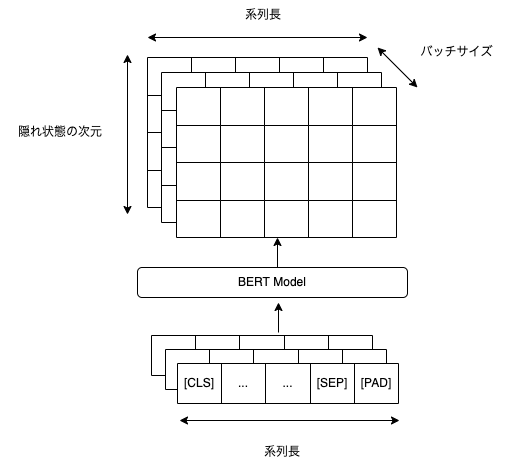

In [27]:
import io
import PIL
from IPython.display import Image, display

def show_pil_img(img):  
    encoded = io.BytesIO()
    img.save(encoded, format='png')
    display(Image(encoded.getvalue()))

pil_img = PIL.Image.open("BERT4_1.png")
show_pil_img(pil_img)

In [23]:
# 4-19
# BERTで推論のみ行うときは、以下のようにBERTの処理を torch.no_grad() で囲む
# 計算の途中経過が保存されなくなり、メモリや計算時間を減らせる
with torch.no_grad():
  output = bert(**encoding)
  last_hidden_state = output.last_hidden_state

In [24]:
# 4-20
# GPUで処理したBERTの出力last_hidden_statesもGPUに配置されている
last_hidden_state = last_hidden_state.cpu() # CPUに移すことも可能
# また、numpy.ndarrayやリストにも変換できる
print(type(last_hidden_state))
last_hidden_state = last_hidden_state.numpy() # numpy.ndarrayに変換
print(type(last_hidden_state))
last_hidden_state = last_hidden_state.tolist() # リストに変換
print(type(last_hidden_state))

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
<class 'list'>
